<a href="https://colab.research.google.com/github/aditya161205/DAV/blob/main/q2_DAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
data=pd.read_csv("student_data.csv")


In [3]:
numeric = data.select_dtypes(include=['float64']).columns
for col in numeric:
    data[col] = data[col].fillna(data[col].median())


cat = data.select_dtypes(include=['object']).columns
for col in cat:
    data[col] = data[col].fillna(data[col].mode()[0])

In [4]:
for col in data.columns:
    if data[col].dtype == 'float64':
        lower = data[col].quantile(0.25)
        upper = data[col].quantile(0.75)
        data[col] = data[col].clip(lower, upper)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Student_ID                     1000 non-null   object 
 1   Age                            1000 non-null   float64
 2   Gender                         1000 non-null   object 
 3   StudyHoursPerDay               1000 non-null   float64
 4   SocialMediaHours               1000 non-null   float64
 5   MovieTvShowHours               1000 non-null   float64
 6   PoR                            1000 non-null   object 
 7   AttendancePercentage           1000 non-null   float64
 8   SleepHoursPerNight             1000 non-null   float64
 9   Diet_Quality                   1000 non-null   object 
 10  Exercise_frequency             1000 non-null   float64
 11  parental_education_level       1000 non-null   object 
 12  internet_quality               1000 non-null   ob

In [5]:

data_encoded=pd.get_dummies(data,columns = ['Gender', 'PoR','Diet_Quality','parental_education_level','internet_quality','extracurricular_participation'], dtype = int, drop_first=True)

X = data_encoded.drop(['Cumulative_Grade', 'Student_ID'], axis=1)
y=data_encoded['Cumulative_Grade']


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)



In [7]:
class LinearRegression:
  def __init__(self)->None:
    self.weights: np.ndarray | None=None
    self.bias: np.ndarray | None=None

  def predict(self,X:np.ndarray)->np.ndarray:
    y_pred=np.dot(self.weights,X.T) + self.bias
    return y_pred

  def __loss(self,X:np.ndarray,y:np.ndarray,norm:int)->tuple:

    y_pred=self.predict(X)
    n=X.shape[0]

    errors=np.abs(y_pred-y)**norm
    loss=np.sum(errors)/n

    gradient_base= norm*np.sign(y_pred-y)*(np.abs(y_pred-y)**(norm-1))
    dw = np.dot(X.T, gradient_base) / n
    db = np.sum(gradient_base) / n

    return loss, dw, db

  def fit(self,X:np.ndarray,y:np.ndarray,learning_rate:float=0.01,epochs:int=500,norm: int = 2, threshold: float = 0.0001)->None:

    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    n_features = X.shape[1]

    self.weights = np.zeros(n_features, dtype=np.float64)
    self.bias = 0.0
    prev_loss = float('inf')

    for epoch in range (epochs):
      curr_loss,dw,db=self.__loss(X, y, norm)
      self.weights-=learning_rate*dw
      self.bias-=learning_rate*db

      if abs(curr_loss-prev_loss)<threshold:
        print(f"Converged at epoch {epoch + 1}. Loss: {curr_loss:.4f}")
        break
      prev_loss=curr_loss




MSE loss:  37.36708469443831


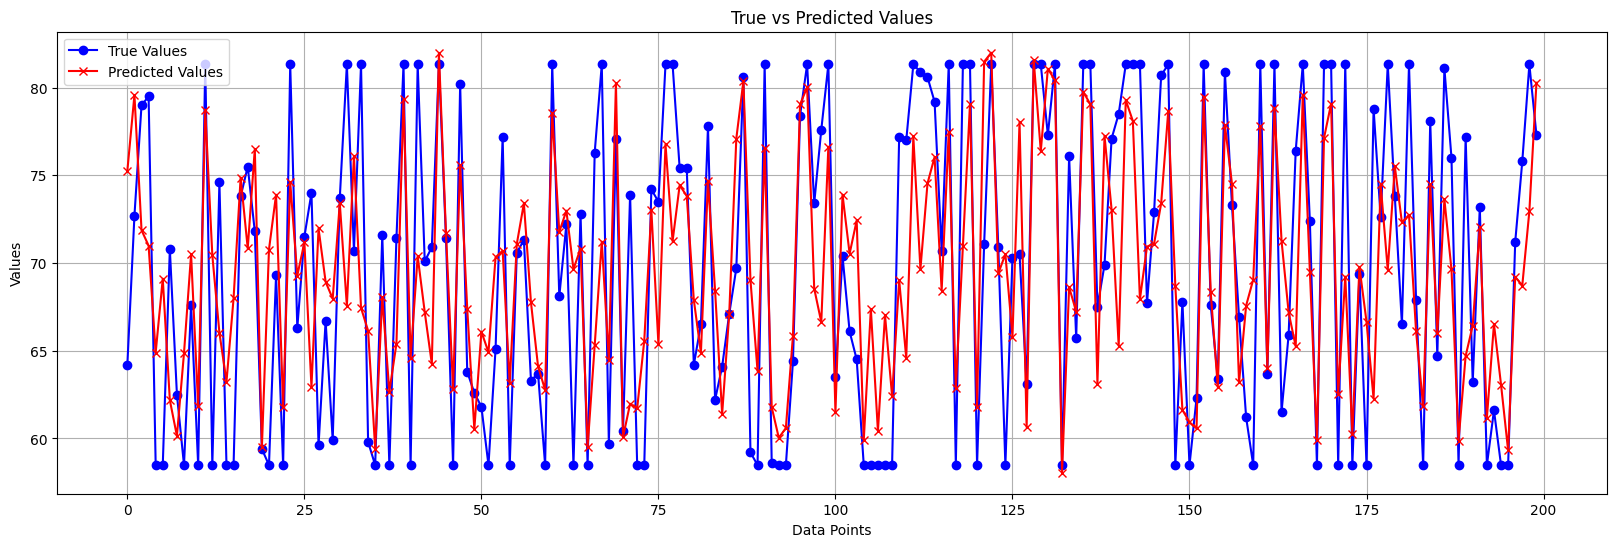

R² Score      : 0.5079
MSE           : 37.3671
RMSE          : 6.1129
MAE           : 4.8794


In [15]:
model = LinearRegression()
model.fit(X_train, y_train, epochs=10000, learning_rate=0.00008, norm=2, threshold=0.0001)
y_pred = model.predict(X_test)

print("MSE loss: ", np.mean((y_pred - y_test) ** 2))

indices = np.arange(len(y_test))
plt.figure(figsize=(20, 6))

plt.plot(indices, y_test, label='True Values', color='blue', marker='o')
plt.plot(indices, y_pred, label='Predicted Values', color='red', marker='x')

plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs Predicted Values')

plt.legend()
plt.grid(True)
plt.show()


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score      : {r2:.4f}")
print(f"MSE           : {mse:.4f}")
print(f"RMSE          : {rmse:.4f}")
print(f"MAE           : {mae:.4f}")



In [17]:

linear_importance = np.abs(model.weights)

linear_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': linear_importance
}).sort_values(by='Importance', ascending=False)

print(linear_df.head(2))

                Feature  Importance
1      StudyHoursPerDay    4.875120
7  mental_health_rating    3.376735


Top 2 fearures are StudyHoursPerDay and mental_health_rating. As we also saw in the graphs in previous question these 2 had strong positive correlation with the target variable which is cumulative grade hence these 2 are most important feature for predicting the grade.

Using Random Forest

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [11]:
class RandomForestRegressor:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_leaf=3, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.trees = []

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.trees = []
        n_samples, n_features = X.shape
        self.max_features = self.max_features or int(np.sqrt(n_features))

        for _ in range(self.n_estimators):
            sample_idx = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample, y_sample = X[sample_idx], y[sample_idx]

            tree_features = np.random.choice(n_features, size=self.max_features, replace=False)
            X_sub = X_sample[:, tree_features]

            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            tree.fit(X_sub, y_sample)

            self.trees.append((tree, tree_features))

    def predict(self, X: np.ndarray):
        predictions = []

        for tree, tree_features in self.trees:
            sub_X = X[:, tree_features]
            sub_pred = tree.predict(sub_X)
            predictions.append(sub_pred)

        predictions = np.array(predictions)
        return np.mean(predictions, axis=0)


MSE loss:  45.192560747713216


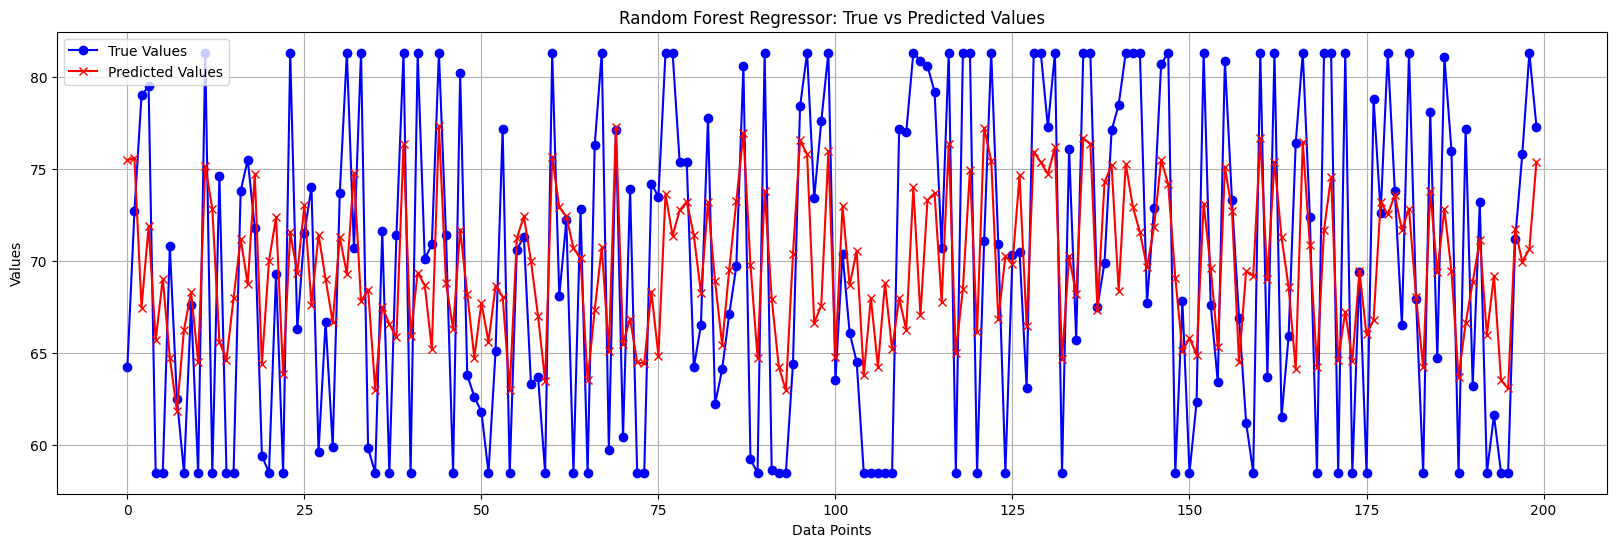

R² Score      : 0.4048
MSE           : 45.1926
RMSE          : 6.7225
MAE           : 5.8675


In [12]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

model = RandomForestRegressor(n_estimators=30, max_depth=8, min_samples_leaf=2, max_features=6)
model.fit(X_train_np, y_train_np)

y_pred = model.predict(X_test_np)

print("MSE loss: ", np.mean((y_pred - y_test_np) ** 2))

indices = np.arange(len(y_test_np))
plt.figure(figsize=(20, 6))

plt.plot(indices, y_test_np, label='True Values', color='blue', marker='o')
plt.plot(indices, y_pred, label='Predicted Values', color='red', marker='x')

plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Random Forest Regressor: True vs Predicted Values')

plt.legend()
plt.grid(True)
plt.show()




r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score      : {r2:.4f}")
print(f"MSE           : {mse:.4f}")
print(f"RMSE          : {rmse:.4f}")
print(f"MAE           : {mae:.4f}")


Linear regression model gave better results than random forest. This is mainly because the random forest model gives better results when the data is discrete. But the cumulative grades are continuous.